<h1>template notebook</h1>

import libraries

In [1]:
#defaul libraries
#https://docs.python.org/ja/
import os
import sys
import io

import math
import random
import pprint
import time
import datetime
import typing
import json
import glob
import requests
import warnings
import gc
from pprint import pprint
import re

import numpy as np #https://numpy.org/
import pandas as pd #https://pandas.pydata.org/
import sklearn #https://scikit-learn.org/stable/

import matplotlib.pyplot as plt #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
%matplotlib inline

import seaborn as sns
sns.set()

from tqdm import tqdm #https://tqdm.github.io/

import torch #https://pytorch.org/
import transformers #https://huggingface.co/transformers/

import torchvision
import torchtext

CFG

In [2]:
class CFG():
    
    data_path="/kaggle/input/digit-recognizer"
    debug=True
    seed=0

    device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
    batch_size=1#32
    epochs=30
    learning_rate=0.1
    kFold=5


    #高速化関連
    #https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587

    #GPU 遅くなるらしい↓
    torch.backends.cudnn.deterministic = True

    #イテレーションごとのnnの順伝搬および誤差関数の 計算手法がある程度一定であれば、torch.backends.cudnn.benchmark = Trueで GPU での計算が高速化
    torch.backends.cudnn.benchmark = False


def set_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(CFG.seed)

print(CFG.device)
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name())

cpu


color

In [3]:
def color(string,fg='DEFAULT',bg='DEFAULT',fg_rgb=None,bg_rgb=None,style='END'):
    colors=['BLACK','RED','GREEN','YELLOW','BLUE','PURPLE','CYAN','WHITE','8','DEFAULT']
    styles=['END','BOLD','2','3','UNDERLINE','5','6','REVERSE','INVISIBLE','9']

    fg=f'\033[3{colors.index(fg)}m'
    bg=f'\033[4{colors.index(bg)}m'
    style=f'\033[0{styles.index(style)}m'

    if fg_rgb:fg=f"\033[38;2;{fg_rgb[0]};{fg_rgb[1]};{fg_rgb[2]}m"
    if bg_rgb:bg=f"\033[48;2;{bg_rgb[0]};{bg_rgb[1]};{bg_rgb[2]}m"

    return style+fg+bg+str(string)+'\033[0m'

In [4]:
print(color("color test","GREEN",style='BOLD'))
print(color("color test","RED","BLUE",style='UNDERLINE'))
print(color("color test","CYAN","WHITE",style='INVISIBLE'))
print(color("color test","CYAN",style='REVERSE'))
print(color("aaa",fg_rgb=(150,150,255)))
# print(color("bbb",fg_rgb=(0,250,50),bg_rgb=(0,0,255)))
# print(color("ccc"))
# print(color('style',bg="RED",fg='BLUE'))
# print('\033[07m'+"Aa")


color test
color test
color test
color test
aaa


In [5]:
def what_is(obj):
    print("type:",type(obj))
    print("-"*40+"help"+"-"*40)
    print(help(obj))
    print("-"*40+"dir"+"-"*40)
    print(dir(obj))

In [6]:
target_columns=['target']
def feature_columns(df):
    for col in df.columns:
        if col in target_columns:df=df.drop(columns=col)
    return  df.columns
def numerical_columns(df):
    return df[feature_columns(df)].select_dtypes(include=['int64','float64']).columns
def categorical_columns(df):
    return df[feature_columns(df)].select_dtypes(exclude=['int64','float64']).columns

read data

In [7]:
# %%script echo skipping

train=pd.read_csv(os.path.join(CFG.data_path,"train.csv"))
test=pd.read_csv(os.path.join(CFG.data_path,"test.csv"))
sample_submission=pd.read_csv(os.path.join(CFG.data_path,"sample_submission.csv"),index_col='ImageId')

# if CFG.debug:
#     #train=train[:len(train)//50]
#     train=train.sample(frac=0.1)

df=pd.concat([train,test])
# train=df[:len(train)].copy()
# test=df[len(train):].copy()

data={
    'train':train,
#     'val':pd.DataFrame({'feature':val.feature,'target':val['target']}),
    'test':test,
}

In [8]:
data['train']

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


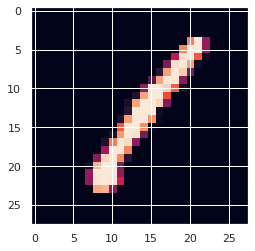

1


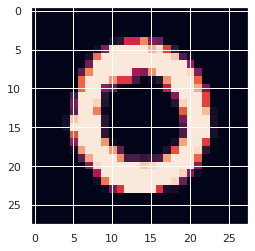

0


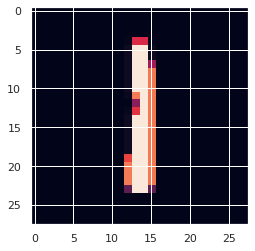

1


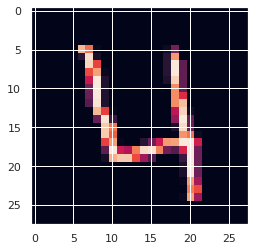

4


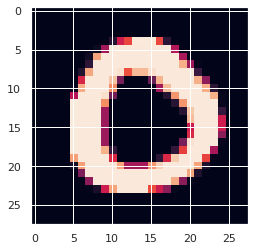

0


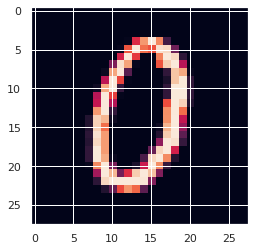

0


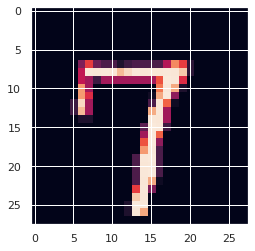

7


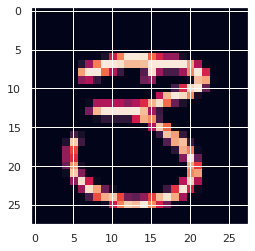

3


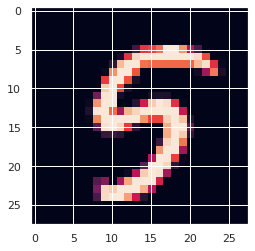

5


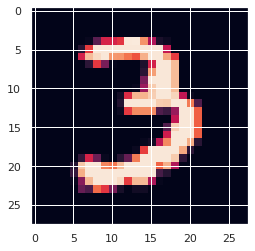

3


In [9]:
for i in range(10):
    plt.imshow(np.array(data['train'].iloc[i,1:]).reshape(28,28))
    plt.show()
    print(data['train'].iloc[i,0])

submission

In [10]:
submission=pd.DataFrame(columns=['idx','target'])

submission.idx=range(5)
submission.target=[1,0,0,1,1]
#submission.to_csv("submission.csv",index=idx)

submission.head()

,idx,target
0,0,1
1,1,0
2,2,0
3,3,1
4,4,1
